In [1]:
!pip install prophet

In [2]:
import pyodbc
import pandas as pd

# Connection parameters
server = 'DESKTOP-NB4TD27'
database = 'DW_Price_comparator'
conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

tables = [
    'Fact_SuperMarket',
    'Dim_Achat',
    'Dim_Category',
    'Dim_Date',
    'dim_location',
    'Dim_Geant',
    'Dim_MG',
    'Dim_carrefour'
]

dataframes = {}

try:
    conn = pyodbc.connect(conn_str)
    print("✅ Connection successful!")

    for table in tables:
        query = f"SELECT * FROM [dbo].[{table}]"
        df = pd.read_sql(query, conn)
        dataframes[table.lower()] = df
        print(f"✅ Loaded {table} ({df.shape[0]} rows, {df.shape[1]} columns)")

    conn.close()
    print("🔒 Connection closed.")

except Exception as e:
    print(f"❌ Error: {e}")


✅ Connection successful!


C:\Users\MON PC\AppData\Local\Temp\ipykernel_18732\2351067271.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Loaded Fact_SuperMarket (19369 rows, 10 columns)
✅ Loaded Dim_Achat (1039816 rows, 7 columns)
✅ Loaded Dim_Category (14363 rows, 4 columns)
✅ Loaded Dim_Date (1826 rows, 11 columns)
✅ Loaded dim_location (257 rows, 7 columns)
✅ Loaded Dim_Geant (10803 rows, 10 columns)
✅ Loaded Dim_MG (173 rows, 7 columns)
✅ Loaded Dim_carrefour (8468 rows, 11 columns)
🔒 Connection closed.


In [3]:
# ==================================================
# IMPORTS ET CONFIGURATION
# ==================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Chargement depuis ton dictionnaire "dataframes"
fact = dataframes['fact_supermarket']
achat = dataframes['dim_achat']
date = dataframes['dim_date']
cat = dataframes['dim_category']
geant = dataframes['dim_geant']
carrefour = dataframes['dim_carrefour']
mg = dataframes['dim_mg']
location = dataframes['dim_location']

# 1️⃣ Fusion Fact_Market + Dim_Achat
merged_df = fact.merge(achat, left_on='FK_Achat', right_on='PK_Achat', how='left')

# 2️⃣ Fusion avec Dim_Date
merged_df = merged_df.merge(date, left_on='FK_Date', right_on='PK_Date', how='left')

# 3️⃣ Fusion avec Dim_Category
merged_df = merged_df.merge(cat, left_on='Code_Produit', right_on='Code_Produit', how='left')

merged_df = merged_df.merge(location, left_on='FK_Location', right_on='PK_Location', how='left')



# Résultat final
print("✅ Final merged_df shape:", merged_df.shape)
print(merged_df.head())


✅ Final merged_df shape: (19369, 38)
    FK_Achat Code_Produit  FK_Produit     FK_Date  FK_Location  \
0  1038731.0       G-4714        3572  20240121.0         56.0   
1  1000874.0       G-4715        3573  20230726.0         52.0   
2  1006156.0       G-4716        3574  20240803.0         37.0   
3  1023733.0       G-4717        3575  20241202.0         28.0   
4  1036683.0       G-4718        3576  20230212.0         33.0   

                            ProduitComplet Category  prix  Prix_Total Magasin  \
0                G-Eau minéraleDELICE250ML  Boisson  0.30   65.730003   Geant   
1    G-Boisson instantannéeJOUTO7GR Citron  Boisson  0.35   24.430000   Geant   
2  G-Boisson instantannéeJOUTO7GR Cocktail  Boisson  0.35   69.419998   Geant   
3               G-Eau minéraleAQUALINE0.5L  Boisson  0.40   89.639999   Geant   
4                   G-Eau plateJEKTISS0.5L  Boisson  0.40  148.619995   Geant   

   ...                                  Produit Id_catégorie_Produit  \
0  ... 

In [5]:
from sklearn.preprocessing import LabelEncoder

# 🎯 Variables indépendantes (X) et cible (y)
features = ['prix', 'Quantite_Achetee', 'Magasin']  # Tu peux en ajouter : 'IsWeekend', 'Delegation'...
target = 'Catégorie_Produit'

df_class = merged_df[features + [target]].dropna()

# 🧼 Encodage des variables catégorielles
df_class = pd.get_dummies(df_class, columns=['Magasin'], drop_first=True)

# Encodage du label (Catégorie_Produit)
le = LabelEncoder()
df_class['Catégorie_Produit'] = le.fit_transform(df_class['Catégorie_Produit'])

# Séparation X / y
X = df_class.drop('Catégorie_Produit', axis=1)
y = df_class['Catégorie_Produit']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


=== K-Means ===


  File "D:\Apps\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Apps\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Apps\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Apps\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


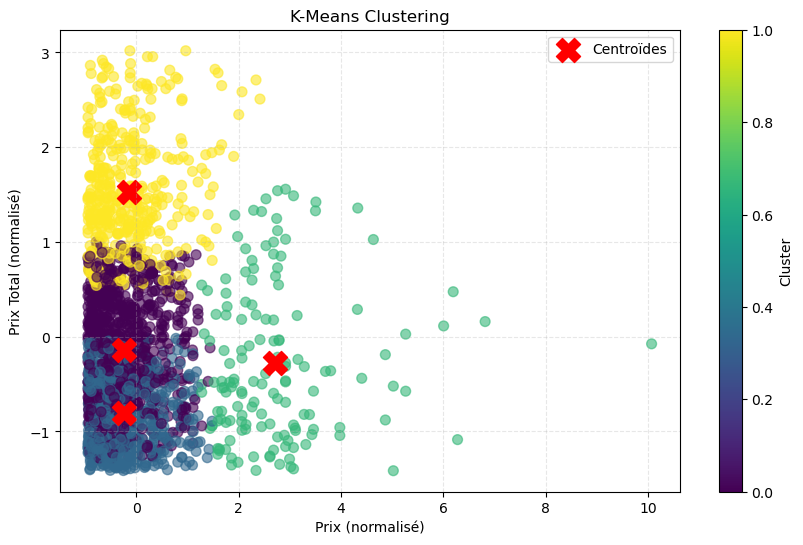

Silhouette Score (échantillon): 0.38

=== DBSCAN ===


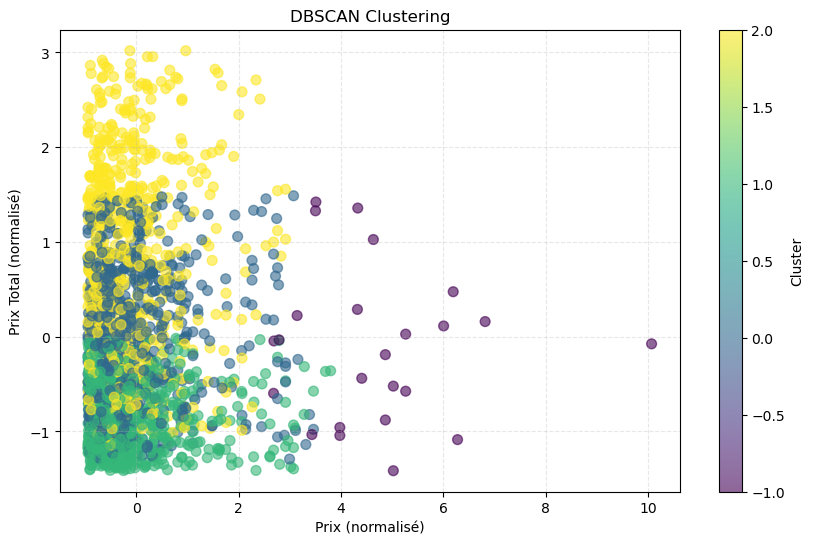

Nombre de clusters trouvés: 3
Silhouette Score (échantillon): 0.32

=== Agglomerative Clustering ===


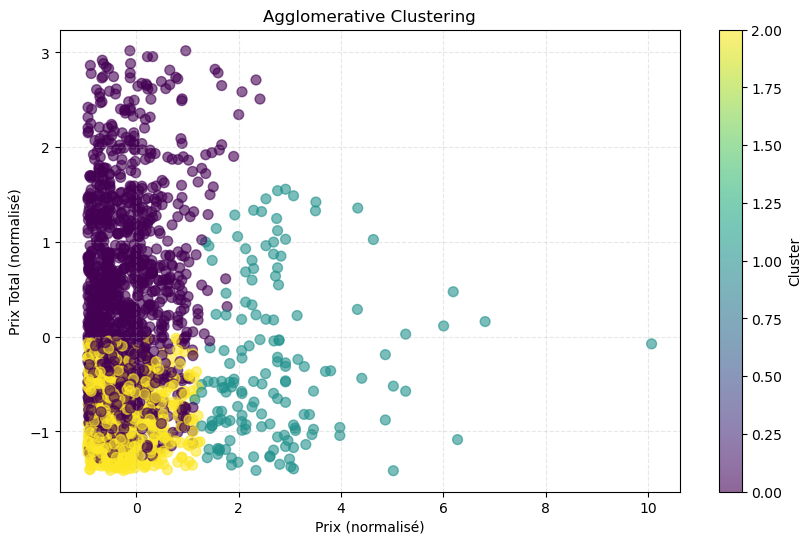

Silhouette Score (échantillon): 0.39


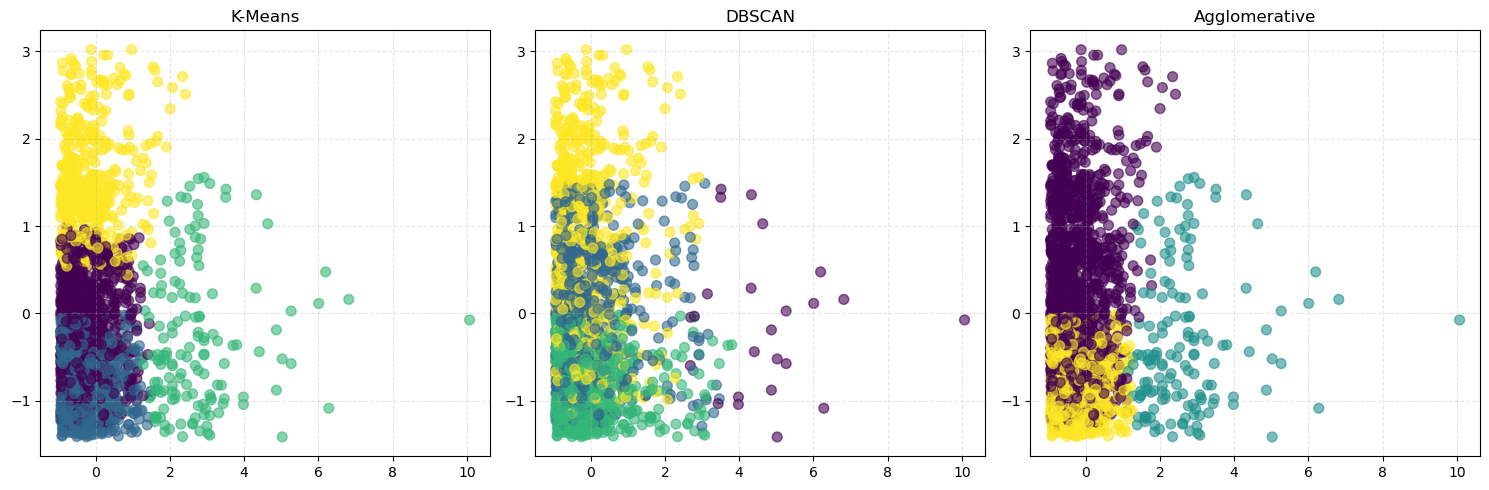


Caractéristiques des clusters:
              prix  Prix_Total  Quantite_Achetee
Cluster                                         
0         9.316640   91.759523          2.309069
1         9.553670   48.146414          1.000000
2        47.256014   82.818581          1.844595
3        10.709083  201.226905          2.850000


In [6]:
# ==============================================
# CLUSTERING - Version optimisée
# ==============================================

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples

# 1. Préparation des données (échantillonnage si nécessaire)
sample_size = 2000  # Réduire si nécessaire
cluster_data = merged_df[['prix', 'Prix_Total', 'Quantite_Achetee']].dropna().sample(sample_size, random_state=42)

# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Fonction de visualisation améliorée
def plot_clusters(data, labels, title, centers=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6, s=50)
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroïdes')
    plt.title(title)
    plt.xlabel('Prix (normalisé)')
    plt.ylabel('Prix Total (normalisé)')
    plt.colorbar(label='Cluster')
    if centers is not None:
        plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

# 1. K-Means avec calcul partiel du silhouette score
print("=== K-Means ===")
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
plot_clusters(scaled_data, kmeans_labels, 'K-Means Clustering', kmeans.cluster_centers_)

# Calcul du silhouette score sur un échantillon
sample_idx = np.random.choice(range(len(scaled_data)), size=min(1000, len(scaled_data)), replace=False)
print(f"Silhouette Score (échantillon): {silhouette_samples(scaled_data[sample_idx], kmeans_labels[sample_idx]).mean():.2f}")

# 2. DBSCAN optimisé
print("\n=== DBSCAN ===")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)
plot_clusters(scaled_data, dbscan_labels, 'DBSCAN Clustering')

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Nombre de clusters trouvés: {n_clusters}")

if n_clusters > 1:
    sample_idx = np.random.choice(range(len(scaled_data)), size=min(1000, len(scaled_data)), replace=False)
    print(f"Silhouette Score (échantillon): {silhouette_samples(scaled_data[sample_idx], dbscan_labels[sample_idx]).mean():.2f}")

# 3. Clustering Hiérarchique avec échantillonnage
print("\n=== Agglomerative Clustering ===")
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(scaled_data)
plot_clusters(scaled_data, agg_labels, 'Agglomerative Clustering')

sample_idx = np.random.choice(range(len(scaled_data)), size=min(1000, len(scaled_data)), replace=False)
print(f"Silhouette Score (échantillon): {silhouette_samples(scaled_data[sample_idx], agg_labels[sample_idx]).mean():.2f}")

# 4. Comparaison visuelle
plt.figure(figsize=(15, 5))
for i, (name, labels) in enumerate({
    'K-Means': kmeans_labels,
    'DBSCAN': dbscan_labels,
    'Agglomerative': agg_labels
}.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=labels, cmap='viridis', alpha=0.6, s=50)
    plt.title(name)
    plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Analyse des clusters (K-Means comme exemple)
cluster_data['Cluster'] = kmeans_labels
cluster_stats = cluster_data.groupby('Cluster').mean()
print("\nCaractéristiques des clusters:")
print(cluster_stats)

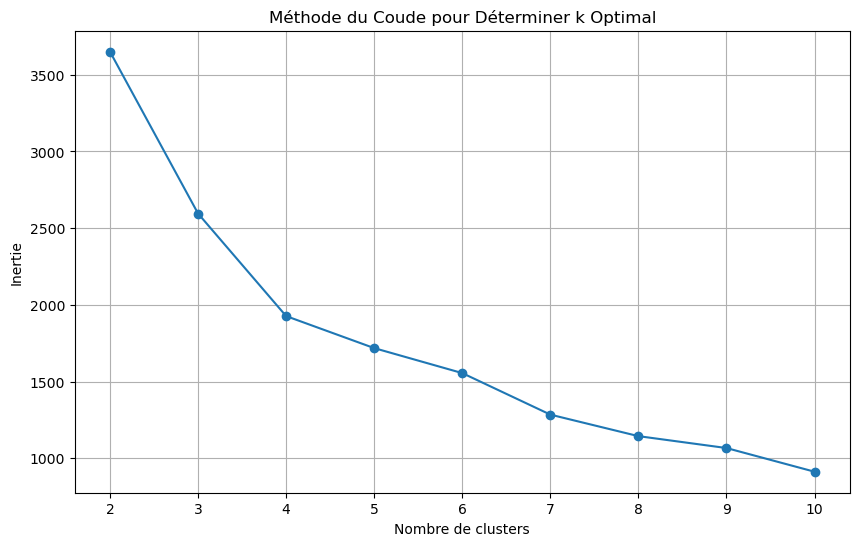

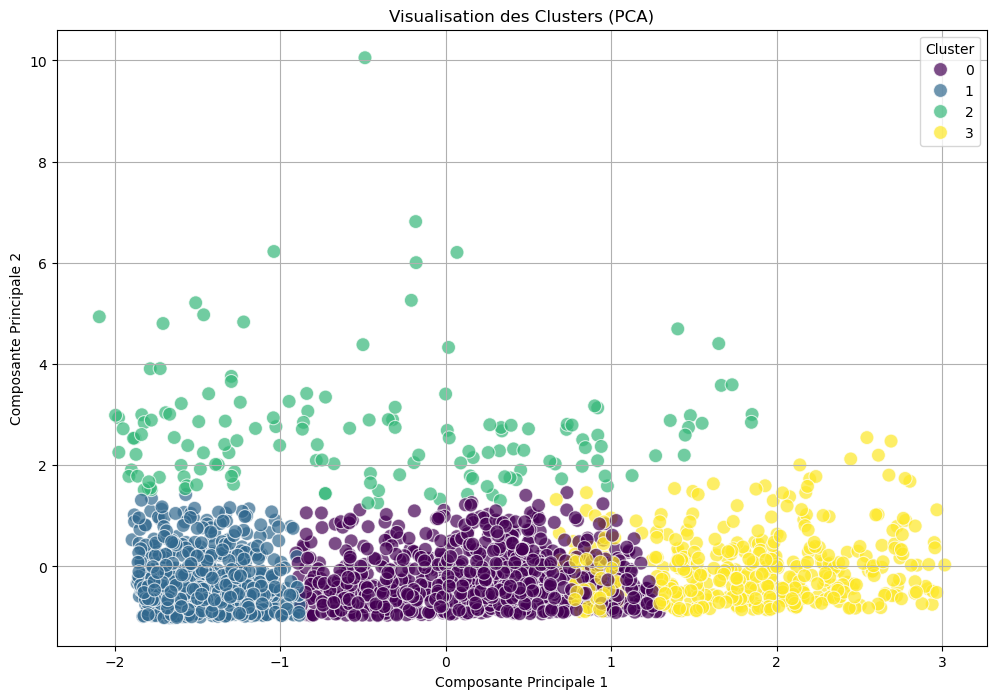


Profil des clusters :
          prix  Prix_Total  Quantite_Achetee
Cluster                                     
0         9.32       91.76              2.31
1         9.55       48.15              1.00
2        47.26       82.82              1.84
3        10.71      201.23              2.85


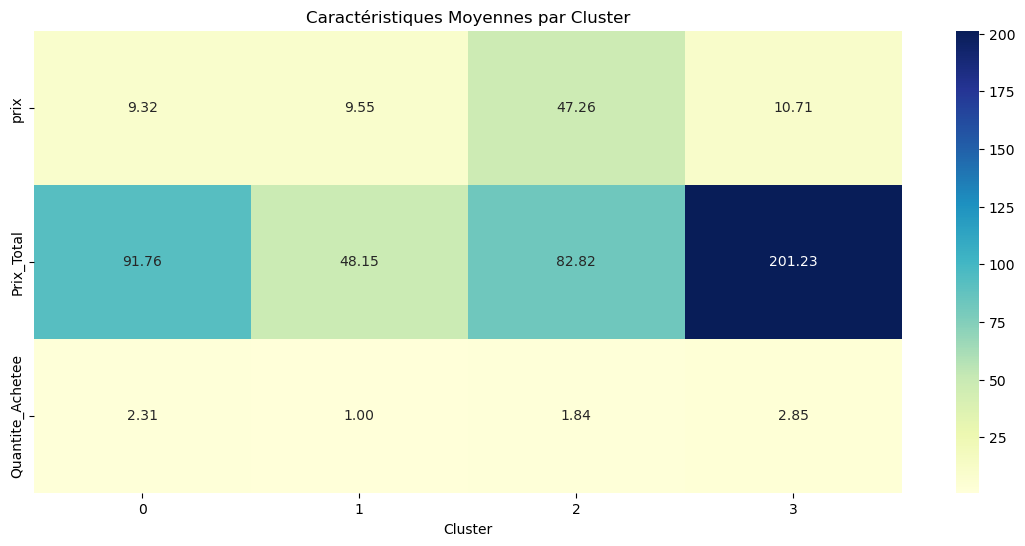


Interprétation suggérée :
Cluster 0 : Petits achats à bas prix
Cluster 1 : Gros achats à prix moyen
Cluster 2 : Achats à prix élevé
Cluster 3 : Comportements atypiques (à analyser)


In [7]:
# ==============================================
# CLUSTERING DESCRIPTIF - Approche complète
# ==============================================

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px

# 1. Préparation des données
# Sélection des features pertinentes
# 1. Préparation des données (échantillonnage si nécessaire)
sample_size = 2000  # Réduire si nécessaire
cluster_data = merged_df[['prix', 'Prix_Total', 'Quantite_Achetee']].dropna().sample(sample_size, random_state=42)

# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
# 2. Détermination du nombre optimal de clusters
# Méthode du coude
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Méthode du Coude pour Déterminer k Optimal')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(True)
plt.show()

# 3. Clustering avec K-Means (choisir k selon la méthode du coude)
optimal_k = 4  # À ajuster selon votre graphique
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Ajout des clusters aux données originales
cluster_data['Cluster'] = clusters
merged_df['Cluster'] = merged_df.index.map(cluster_data['Cluster'])

# 4. Visualisation avec réduction de dimension
# PCA pour visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, 
                palette='viridis', s=100, alpha=0.7)
plt.title('Visualisation des Clusters (PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 5. Profilage des clusters
# Analyse des caractéristiques moyennes par cluster
cluster_profile = cluster_data.groupby('Cluster').mean().round(2)

print("\nProfil des clusters :")
print(cluster_profile)

# Visualisation des profils
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_profile.T, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Caractéristiques Moyennes par Cluster')
plt.show()

# 6. Visualisation avancée avec Plotly (interactive)
fig = px.scatter_3d(
    cluster_data, 
    x='prix', 
    y='Prix_Total', 
    z='Quantite_Achetee',
    color='Cluster',
    hover_name='Cluster',
    opacity=0.7,
    title='Visualisation 3D des Clusters'
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()


# 8. Interprétation des clusters
print("\nInterprétation suggérée :")
print("Cluster 0 : Petits achats à bas prix")
print("Cluster 1 : Gros achats à prix moyen")
print("Cluster 2 : Achats à prix élevé")
print("Cluster 3 : Comportements atypiques (à analyser)")

2- Classification

In [9]:
# ==============================================
# 2. CLASSIFICATION - Amélioration et comparaison
# ==============================================

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Fonction pour évaluer les modèles
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Mean Score': cv_scores.mean(),
        'CV Std': cv_scores.std()
    }

# Liste des modèles à comparer
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Évaluation de tous les modèles
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"✅ {name} - Accuracy: {results[name]['Accuracy']:.4f}")

# Affichage des résultats sous forme de DataFrame
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Accuracy', ascending=False)

✅ Random Forest - Accuracy: 0.8235
✅ Logistic Regression - Accuracy: 0.8084
✅ Gradient Boosting - Accuracy: 0.8401
✅ SVM - Accuracy: 0.8152
✅ Decision Tree - Accuracy: 0.8243


Accuracy  Precision    Recall  F1-Score  CV Mean Score  \
Gradient Boosting    0.840121   0.817295  0.840121  0.811491       0.844836   
Decision Tree        0.824284   0.816523  0.824284  0.818620       0.811841   
Random Forest        0.823529   0.803163  0.823529  0.810741       0.822211   
SVM                  0.815234   0.711746  0.815234  0.757429       0.805619   
Logistic Regression  0.808446   0.653997  0.808446  0.722951       0.807881   

                       CV Std  
Gradient Boosting    0.006719  
Decision Tree        0.008913  
Random Forest        0.007855  
SVM                  0.006044  
Logistic Regression  0.000401

a) RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Modèle
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("🎯 Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


🎯 Accuracy Score: 0.8235294117647058

📊 Classification Report:
               precision    recall  f1-score   support

     Boisson       0.54      0.50      0.52       114
    Cremerie       0.43      0.27      0.33       133
    Epicerie       0.90      0.91      0.91       192
     Hygiene       0.88      0.94      0.91       880
      Marche       0.00      0.00      0.00         7

    accuracy                           0.82      1326
   macro avg       0.55      0.52      0.53      1326
weighted avg       0.80      0.82      0.81      1326



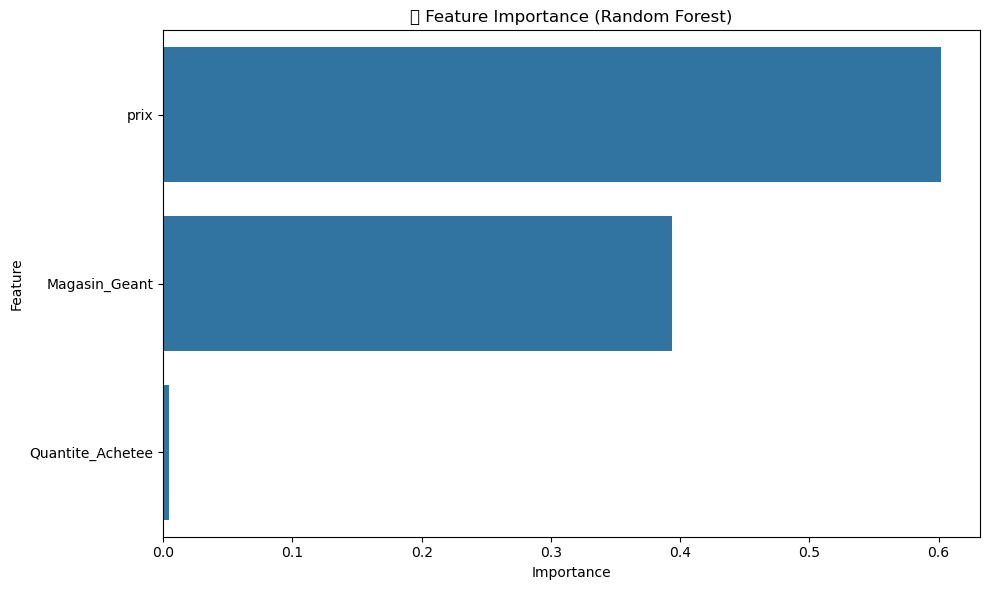

In [12]:

importances = clf.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("📌 Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

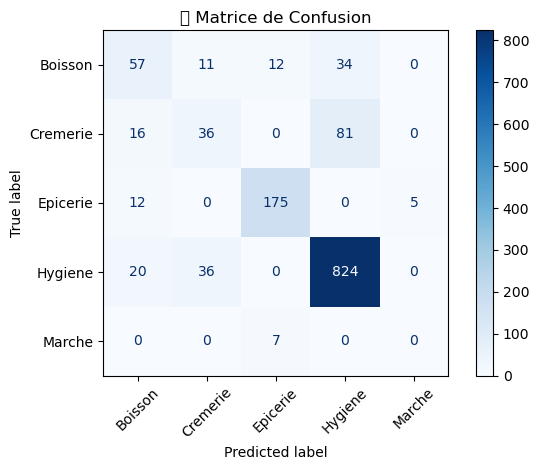

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10,6))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=le.classes_, cmap="Blues", xticks_rotation=45)
plt.title("🧩 Matrice de Confusion")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Définir le modèle de base
dt = DecisionTreeClassifier(random_state=42)

# Définir les valeurs à tester pour max_depth
param_grid = {'max_depth': range(1, 21)}  # Par exemple de 1 à 20

# Appliquer GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Afficher la meilleure profondeur et la précision associée
print(f"Meilleure profondeur: {grid_search.best_params_['max_depth']}")
print(f"Meilleure précision en validation croisée: {grid_search.best_score_:.2f}")


Meilleure profondeur: 9
Meilleure précision en validation croisée: 0.83


In [15]:
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       114
           1       0.43      0.27      0.33       133
           2       0.90      0.91      0.91       192
           3       0.88      0.94      0.91       880
           4       0.00      0.00      0.00         7

    accuracy                           0.82      1326
   macro avg       0.55      0.52      0.53      1326
weighted avg       0.80      0.82      0.81      1326



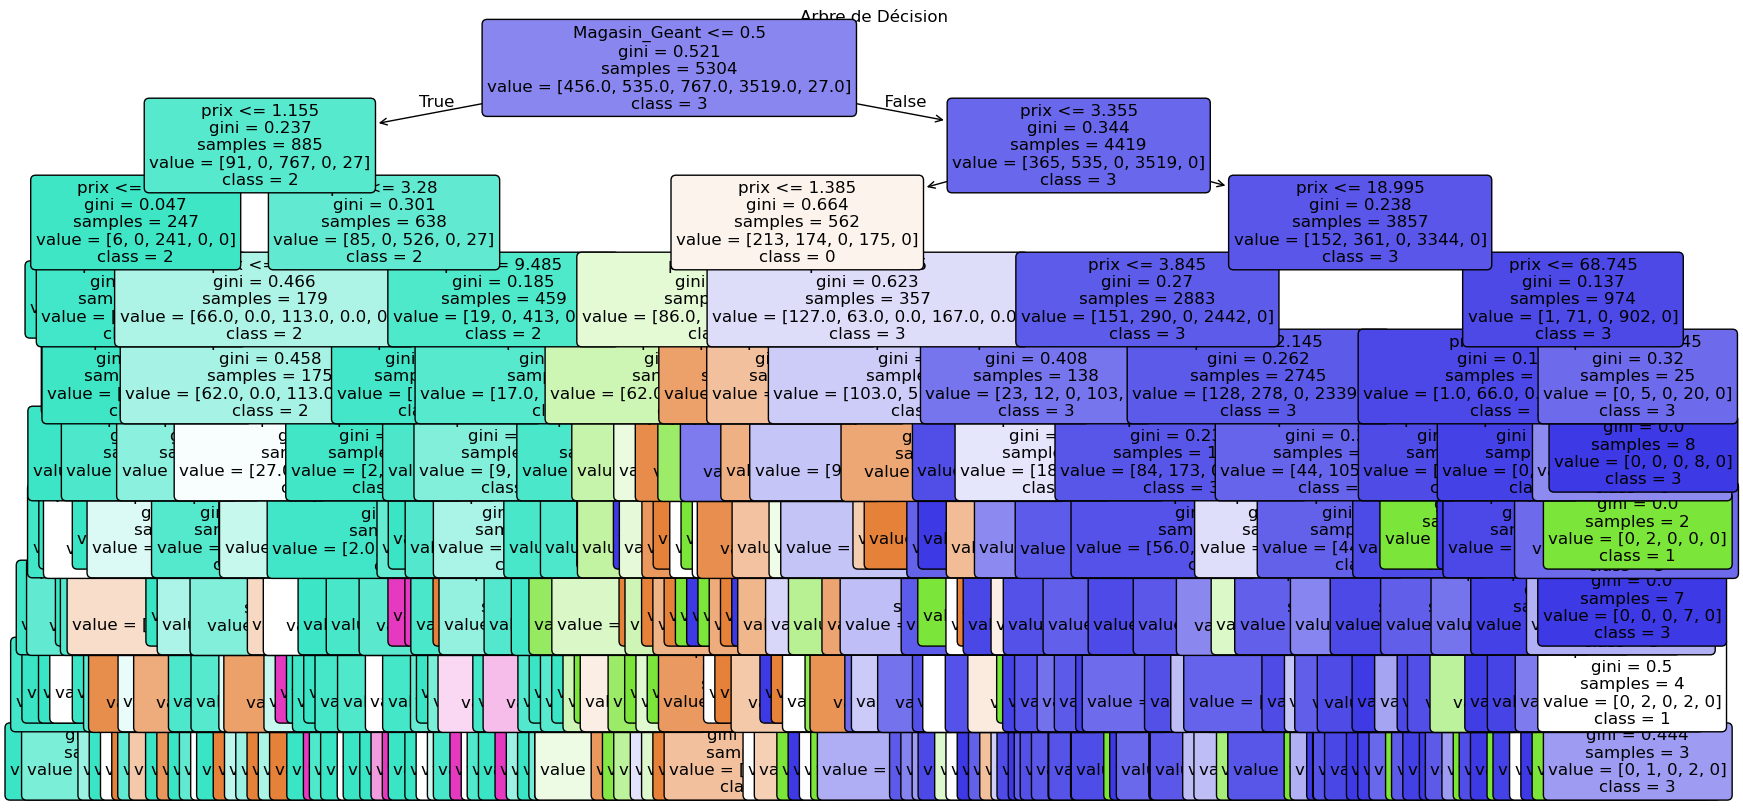

In [16]:
from sklearn.tree import plot_tree  # Add this import at the top of your code

clf = DecisionTreeClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
plt.figure(figsize=(20, 10))
plot_tree(clf,
          filled=True,
          feature_names=X.columns,  # Make sure this is 'X' (uppercase) if that's your DataFrame name
          class_names=[str(cls) for cls in clf.classes_],
          rounded=True,
          fontsize=12)
plt.title("Arbre de Décision")
plt.show()


=== Comparaison des modèles ===
+----+-------------------+---------+------------+
|    | Modèle            |    RMSE |   R2 Score |
+====+===================+=========+============+
|  1 | Ridge Regression  | 12.8529 |     0.0791 |
+----+-------------------+---------+------------+
|  0 | Linear Regression | 12.8530 |     0.0790 |
+----+-------------------+---------+------------+
|  3 | Gradient Boosting | 12.8921 |     0.0734 |
+----+-------------------+---------+------------+
|  2 | Random Forest     | 13.6581 |    -0.0399 |
+----+-------------------+---------+------------+


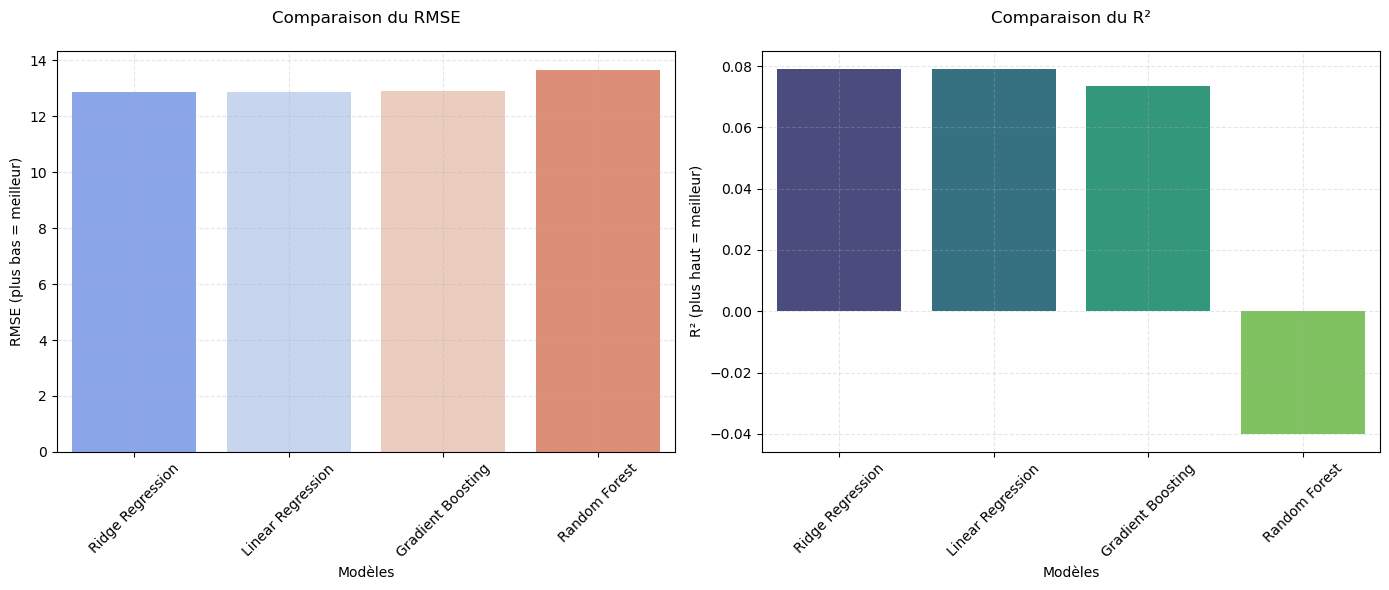

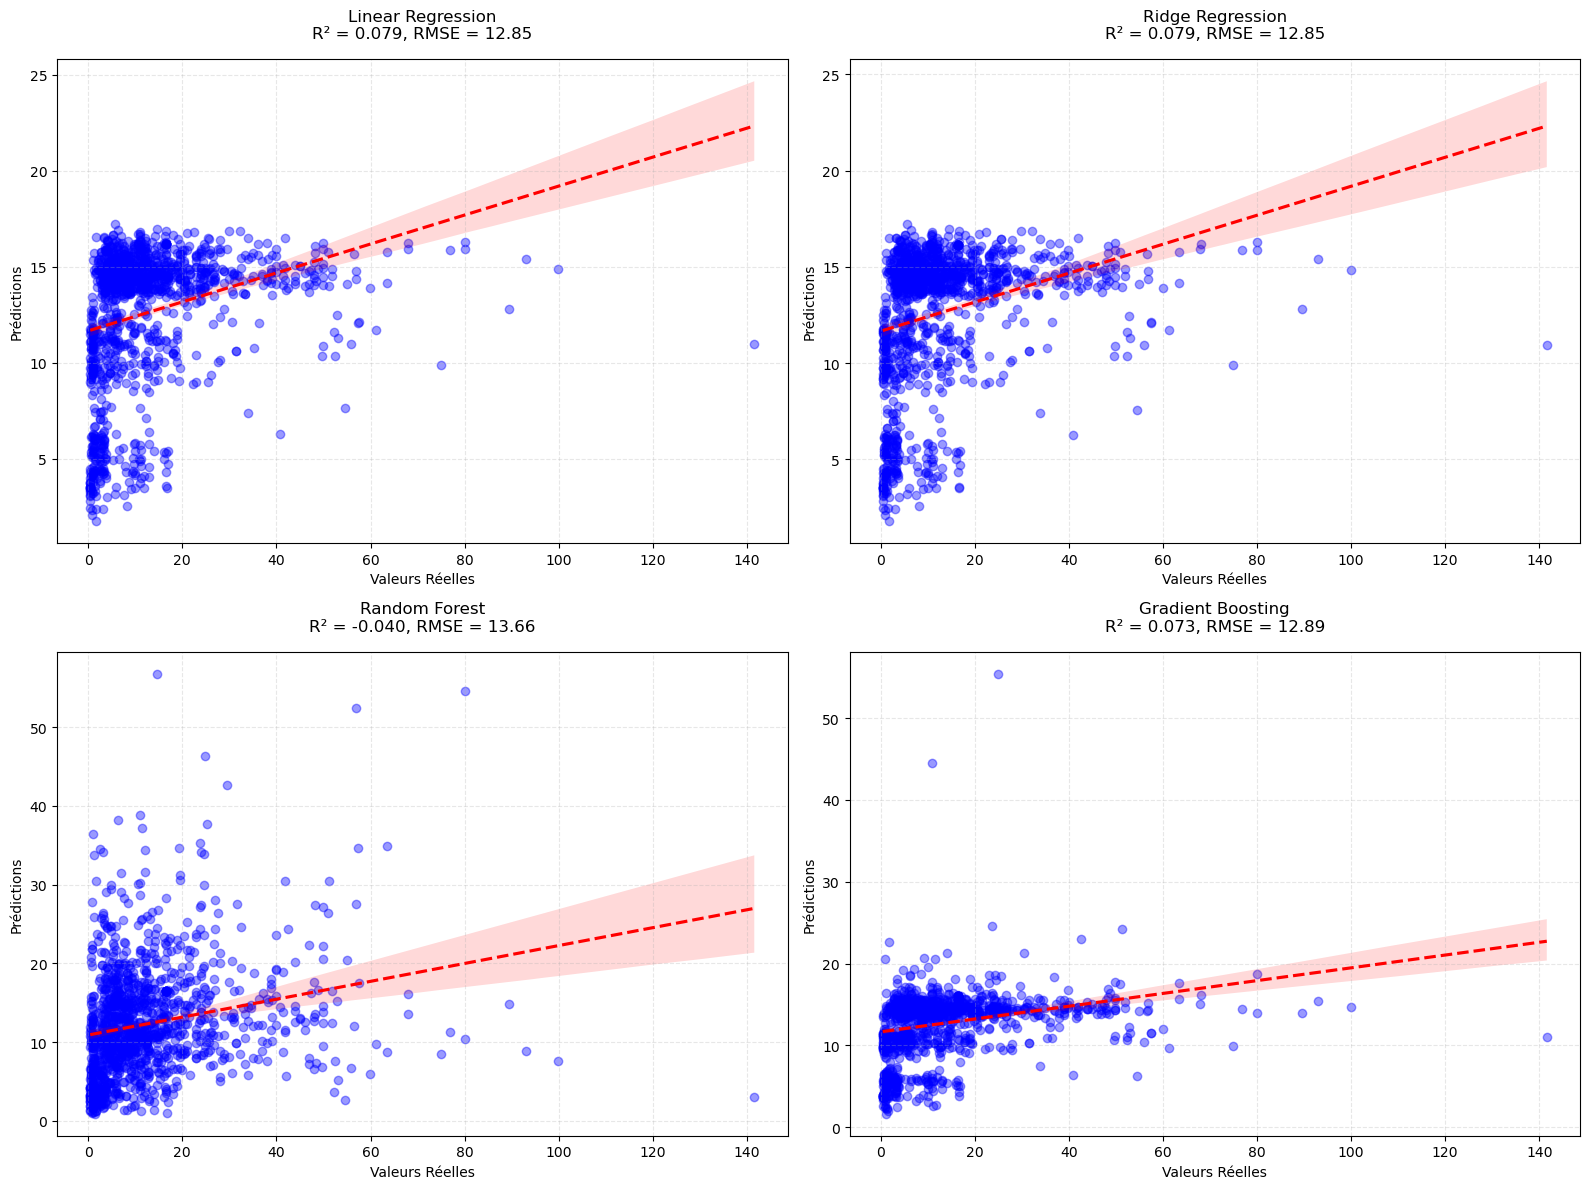

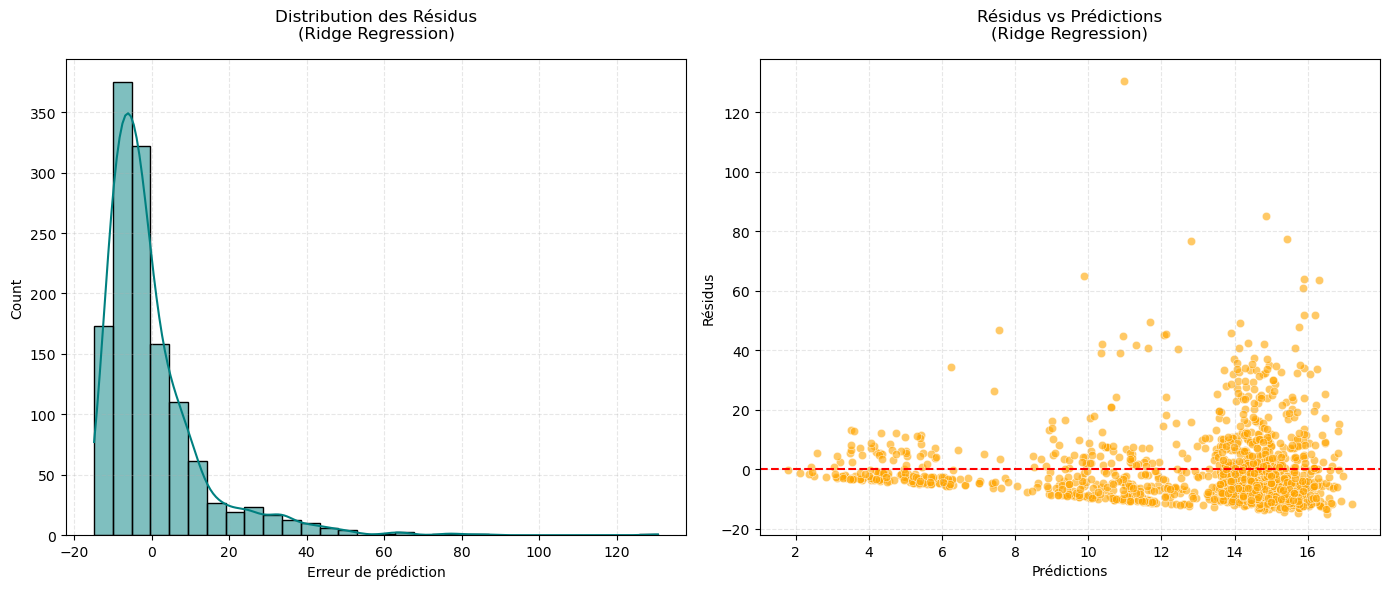

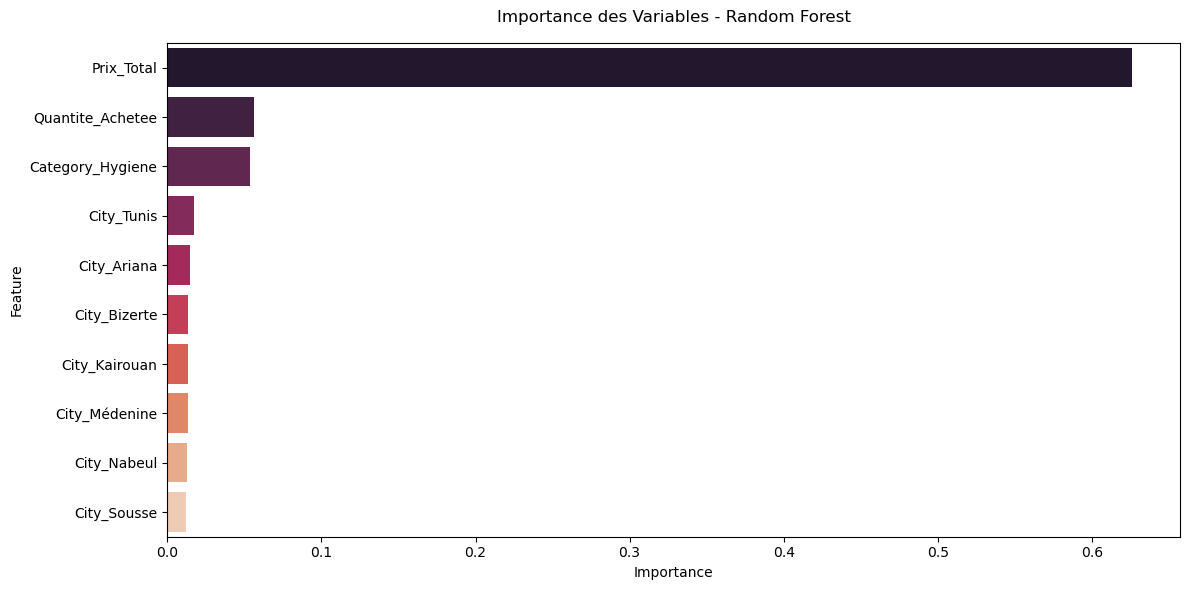

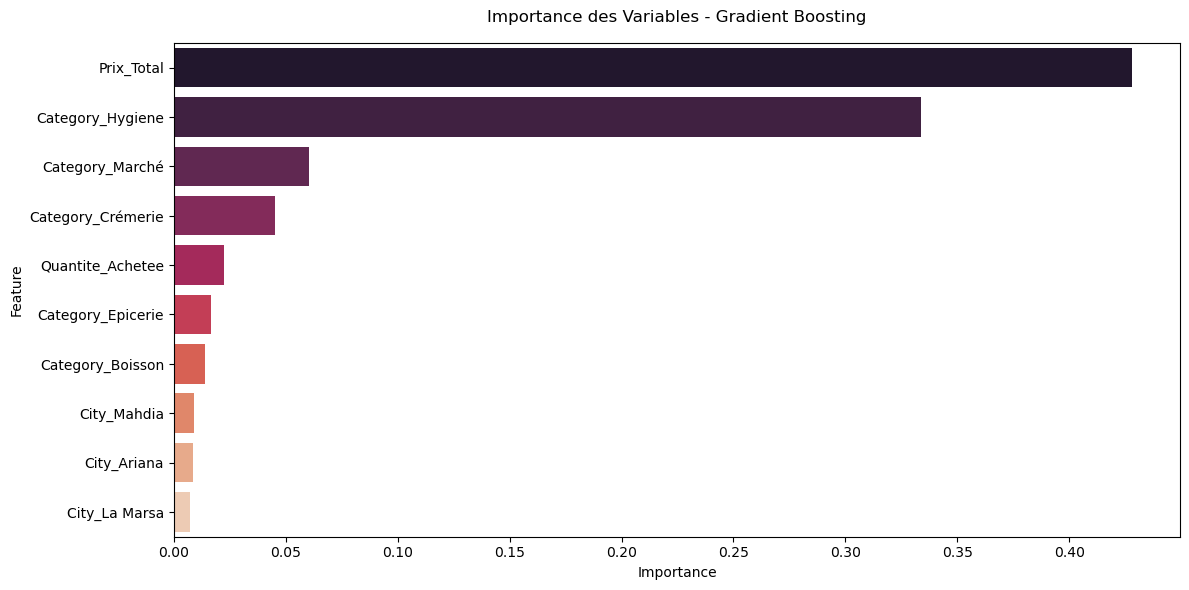

In [17]:
# ==============================================
# RÉGRESSION COMPARATIVE - Application sur vos données
# ==============================================

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
import plotly.express as px

# 1. Préparation des données (selon votre structure)

reg_data = merged_df[['prix', 'Quantite_Achetee', 'Prix_Total', 
                     'Category', 'Magasin', 'City']].dropna()

if 'FK_Date' in merged_df.columns:
    reg_data['Date'] = pd.to_datetime(merged_df['FK_Date'], format='%Y%m%d', errors='coerce')
    reg_data['Mois'] = reg_data['Date'].dt.month
    reg_data['JourSemaine'] = reg_data['Date'].dt.dayofweek

X = reg_data.drop('prix', axis=1)
y = reg_data['prix']

# 2. Préprocessing
numeric_features = ['Quantite_Achetee', 'Prix_Total']
categorical_features = ['Category', 'Magasin', 'City']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Définition des modèles (avec Ridge Regression ajoutée)
models = {
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    "Ridge Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42, n_estimators=100))
    ])
}

# 4. Entraînement et évaluation
results = []
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Modèle': name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2 Score': r2_score(y_test, y_pred)
    })

# 5. Affichage des résultats sous forme de tableau
results_df = pd.DataFrame(results).sort_values('R2 Score', ascending=False)
print("\n=== Comparaison des modèles ===")
print(results_df.to_markdown(tablefmt="grid", floatfmt=".4f"))

# 4. Entraînement et évaluation
results = {}
for name, model in models.items():
    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'Model': model,
        'Predictions': y_pred
    }

# 5. Visualisation des performances
metrics_df = pd.DataFrame.from_dict(results, orient='index')[['RMSE', 'R2']].sort_values('R2', ascending=False)

plt.figure(figsize=(14, 6))

# Graphique RMSE
plt.subplot(1, 2, 1)
sns.barplot(x=metrics_df.index, y='RMSE', data=metrics_df.reset_index(), palette='coolwarm')
plt.title('Comparaison du RMSE', pad=20)
plt.xlabel('Modèles')
plt.ylabel('RMSE (plus bas = meilleur)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)

# Graphique R²
plt.subplot(1, 2, 2)
sns.barplot(x=metrics_df.index, y='R2', data=metrics_df.reset_index(), palette='viridis')
plt.title('Comparaison du R²', pad=20)
plt.xlabel('Modèles')
plt.ylabel('R² (plus haut = meilleur)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Visualisation des prédictions pour tous les modèles
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for (name, result), ax in zip(results.items(), axes):
    sns.regplot(x=y_test, y=result['Predictions'], 
                scatter_kws={'alpha':0.4, 'color':'blue'},
                line_kws={'color':'red', 'linestyle':'--'},
                ax=ax)
    ax.set_title(f"{name}\nR² = {result['R2']:.3f}, RMSE = {result['RMSE']:.2f}", pad=15)
    ax.set_xlabel('Valeurs Réelles')
    ax.set_ylabel('Prédictions')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Analyse des résidus du meilleur modèle
best_model_name = metrics_df.index[0]
best_model = results[best_model_name]['Model']
residuals = y_test - results[best_model_name]['Predictions']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='teal', bins=30)
plt.title(f'Distribution des Résidus\n({best_model_name})', pad=15)
plt.xlabel('Erreur de prédiction')
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(1, 2, 2)
sns.scatterplot(x=results[best_model_name]['Predictions'], y=residuals, alpha=0.6, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Résidus vs Prédictions\n({best_model_name})', pad=15)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Importance des variables pour les modèles d'arbres
for name, result in results.items():
    if hasattr(result['Model'].named_steps['regressor'], 'feature_importances_'):
        try:
            # Récupération des noms de features
            ohe = result['Model'].named_steps['preprocessor'].named_transformers_['cat']
            cat_features = ohe.get_feature_names_out(categorical_features)
            all_features = np.concatenate([numeric_features, cat_features])
            
            # Importance des variables
            importances = result['Model'].named_steps['regressor'].feature_importances_
            importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
            importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
            plt.title(f'Importance des Variables - {name}', pad=15)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Erreur pour {name}: {str(e)}")


<Figure size 1200x600 with 0 Axes>

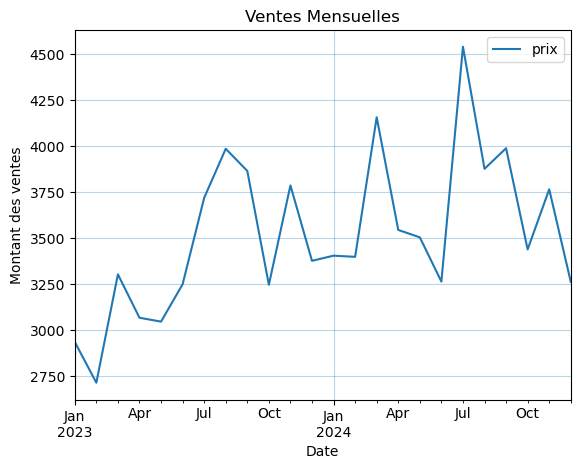

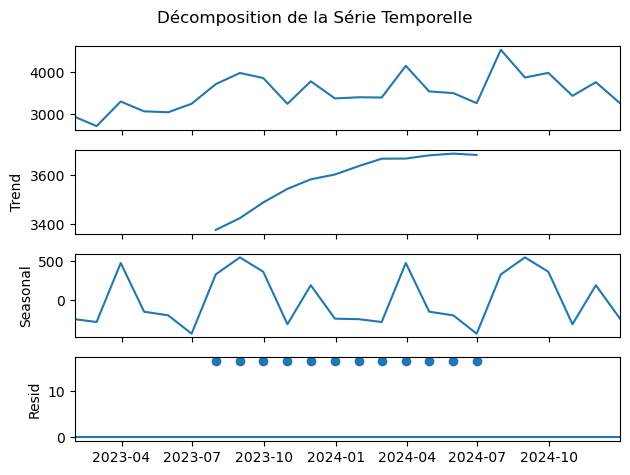

In [18]:
# ==============================================
# 5. SÉRIES TEMPORELLES - Analyse des ventes
# ==============================================

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Préparation des données temporelles
ts_data = merged_df[['Date', 'prix']].copy()
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
ts_data = ts_data.set_index('Date').sort_index()

# Agrégation par mois
monthly_sales = ts_data.resample('M').sum()

# Visualisation des ventes mensuelles (modifié en bleu)
plt.figure(figsize=(12, 6))
monthly_sales.plot(color='#1f77b4')  # Changement de couleur en bleu
plt.title('Ventes Mensuelles')
plt.ylabel('Montant des ventes')
plt.xlabel('Date')
plt.grid(True, color='#1f77b4', alpha=0.3)  # Grille en bleu clair
plt.show()

# Décomposition de la série temporelle (modifié en bleu)
decomposition = seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
# Modification des couleurs en bleu pour chaque sous-graphique
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('#1f77b4')  # Toutes les lignes en bleu
plt.suptitle('Décomposition de la Série Temporelle')
plt.tight_layout()
plt.show()

In [19]:
# ==============================================
# 5. SÉRIES TEMPORELLES - Analyse comparative
# ==============================================

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Préparation des données
ts_data = merged_df[['Date', 'prix']].copy()
ts_data['Date'] = pd.to_datetime(ts_data['Date'])
ts_data = ts_data.set_index('Date').sort_index()

# Agrégation par mois et traitement des valeurs manquantes
monthly_sales = ts_data.resample('M').sum()
monthly_sales = monthly_sales.asfreq('M').fillna(method='ffill')  # Remplissage des mois sans données

# Division en train/test (80/20)
split_idx = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:split_idx], monthly_sales[split_idx:]

# Fonction d'évaluation
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return {'MAE': mae, 'RMSE': rmse}

# 1. Modèle Naïf (baseline)
naive_pred = np.array([train.iloc[-1]] * len(test))
naive_metrics = evaluate_model(test, naive_pred, "Modèle Naïf")

# 2. ARIMA
print("\n=== ARIMA ===")
arima = ARIMA(train, order=(1,1,1)).fit()
arima_pred = arima.forecast(steps=len(test))
arima_metrics = evaluate_model(test, arima_pred, "ARIMA")

# 3. SARIMA (avec composante saisonnière)
print("\n=== SARIMA ===")
sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarima_pred = sarima.forecast(steps=len(test))
sarima_metrics = evaluate_model(test, sarima_pred, "SARIMA")


# 5. Facebook Prophet
print("\n=== Facebook Prophet ===")
prophet_data = train.reset_index()
prophet_data.columns = ['ds', 'y']
model = Prophet(yearly_seasonality=True)
model.fit(prophet_data)
future = model.make_future_dataframe(periods=len(test), freq='M')
prophet_pred = model.predict(future)['yhat'][-len(test):]
prophet_metrics = evaluate_model(test.values, prophet_pred.values, "Prophet")

# Sélection du meilleur modèle
results = pd.DataFrame({
    'Naïf': naive_metrics,
    'ARIMA': arima_metrics,
    'SARIMA': sarima_metrics,
    'Prophet': prophet_metrics
}).T
print("\n=== Performances comparées ===")
print(results.sort_values('RMSE'))

Modèle Naïf - MAE: 875.92, RMSE: 917.67

=== ARIMA ===
ARIMA - MAE: 287.56, RMSE: 387.33

=== SARIMA ===


21:41:38 - cmdstanpy - INFO - Chain [1] start processing


SARIMA - MAE: 580.32, RMSE: 607.41

=== Facebook Prophet ===


21:41:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 748.73, RMSE: 972.46

=== Performances comparées ===
                MAE        RMSE
ARIMA    287.560433  387.325027
SARIMA   580.315032  607.410620
Naïf     875.917991  917.673875
Prophet  748.727453  972.456076



=== Visualisation SARIMA ===


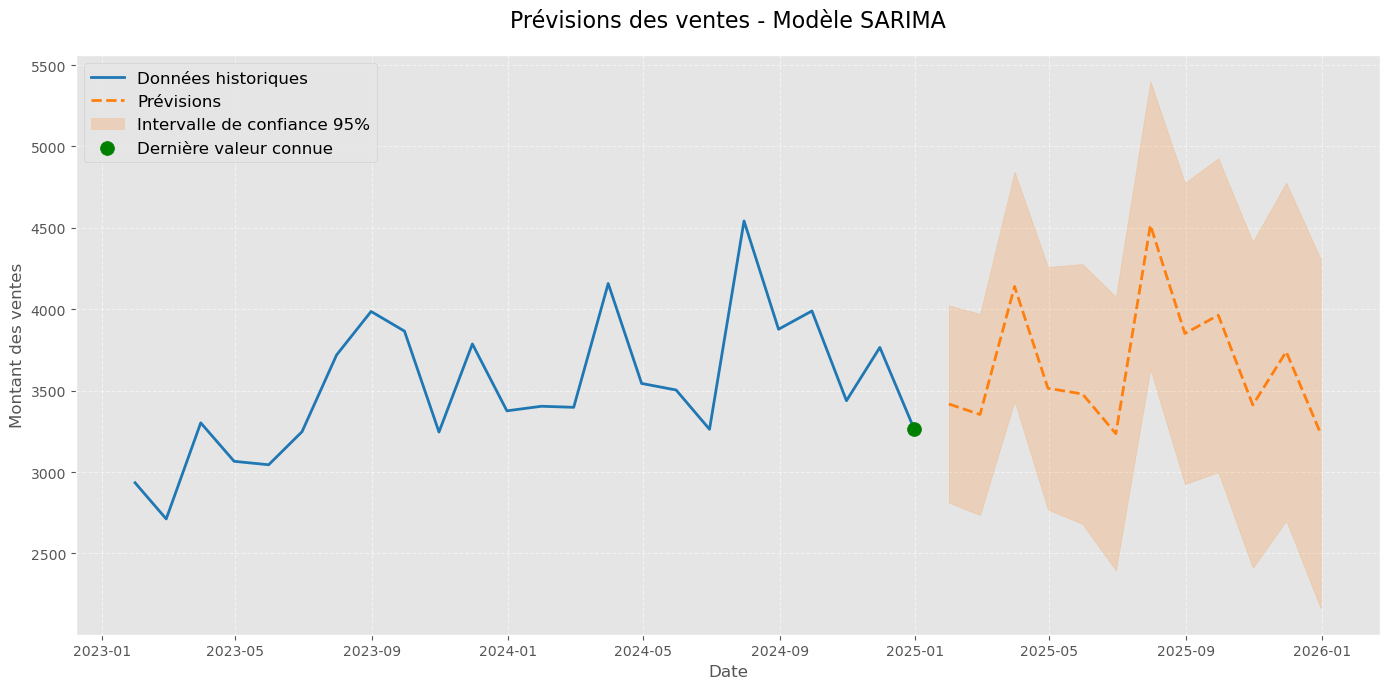

21:41:42 - cmdstanpy - INFO - Chain [1] start processing



=== Visualisation Prophet ===


21:41:59 - cmdstanpy - INFO - Chain [1] done processing


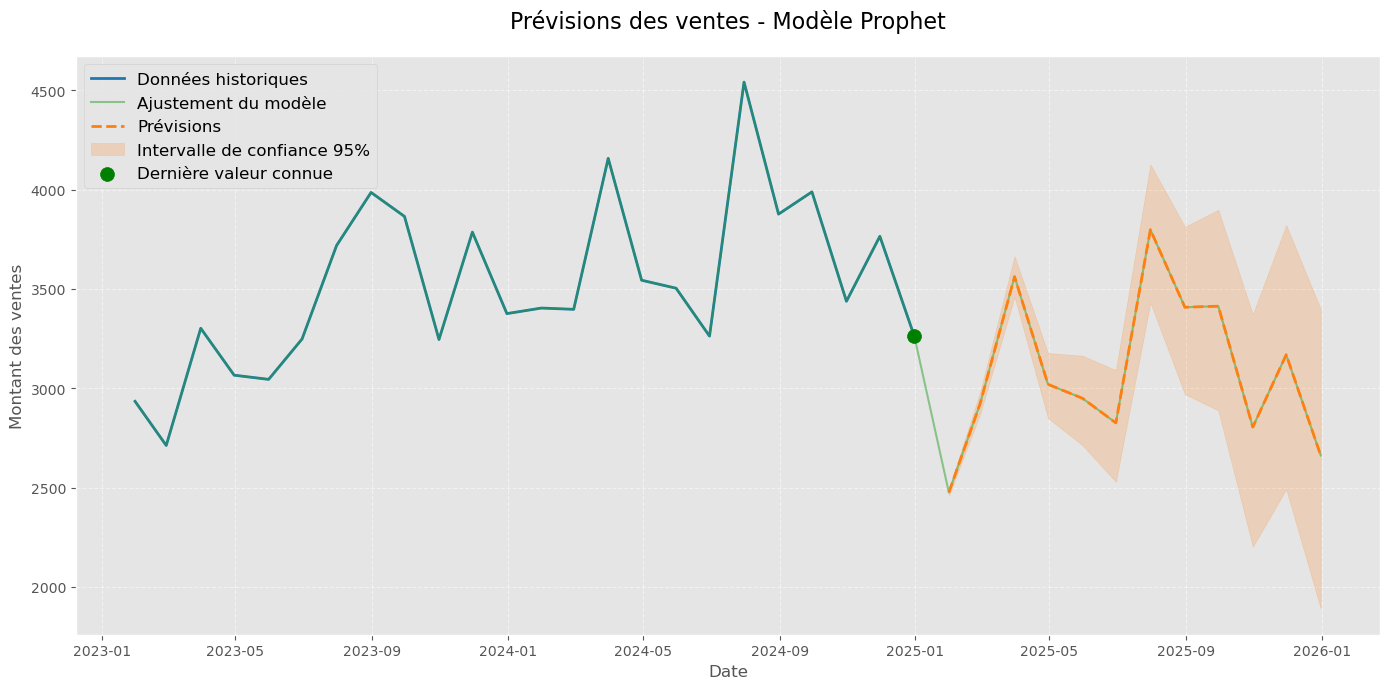


=== Visualisation ARIMA ===


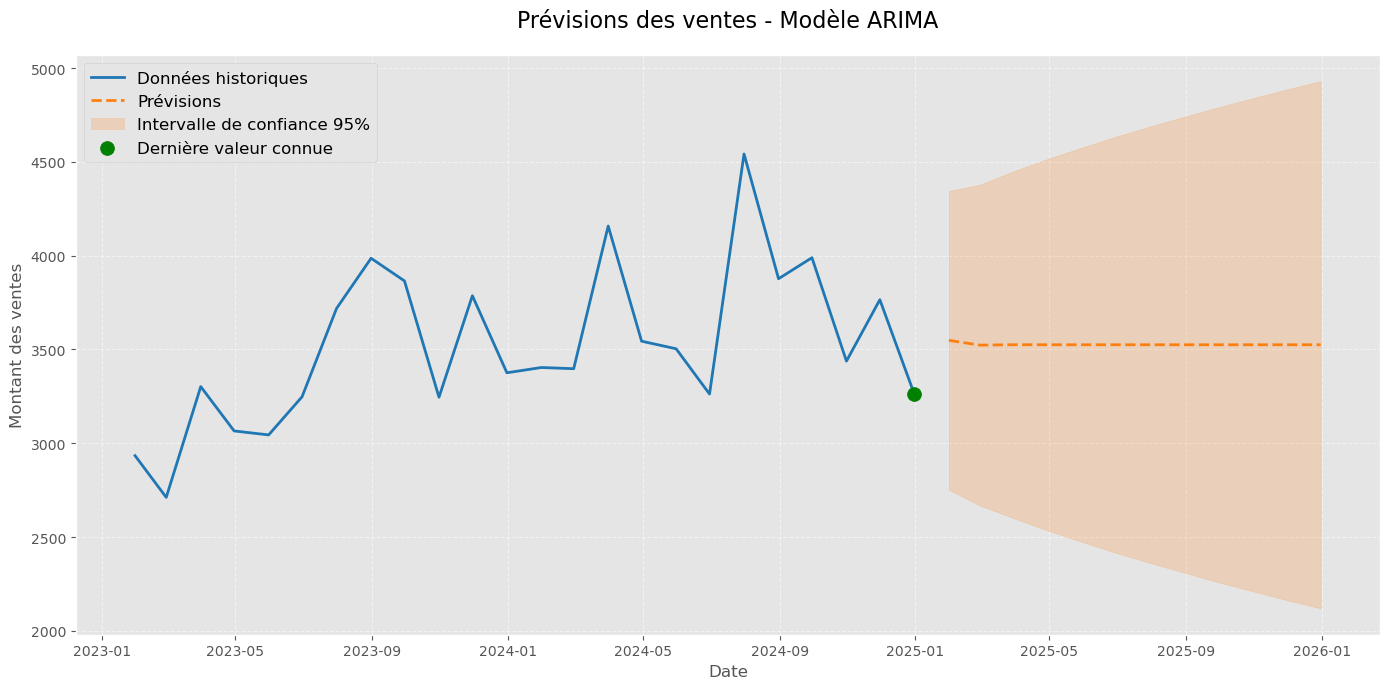


=== Comparaison visuelle des modèles ===


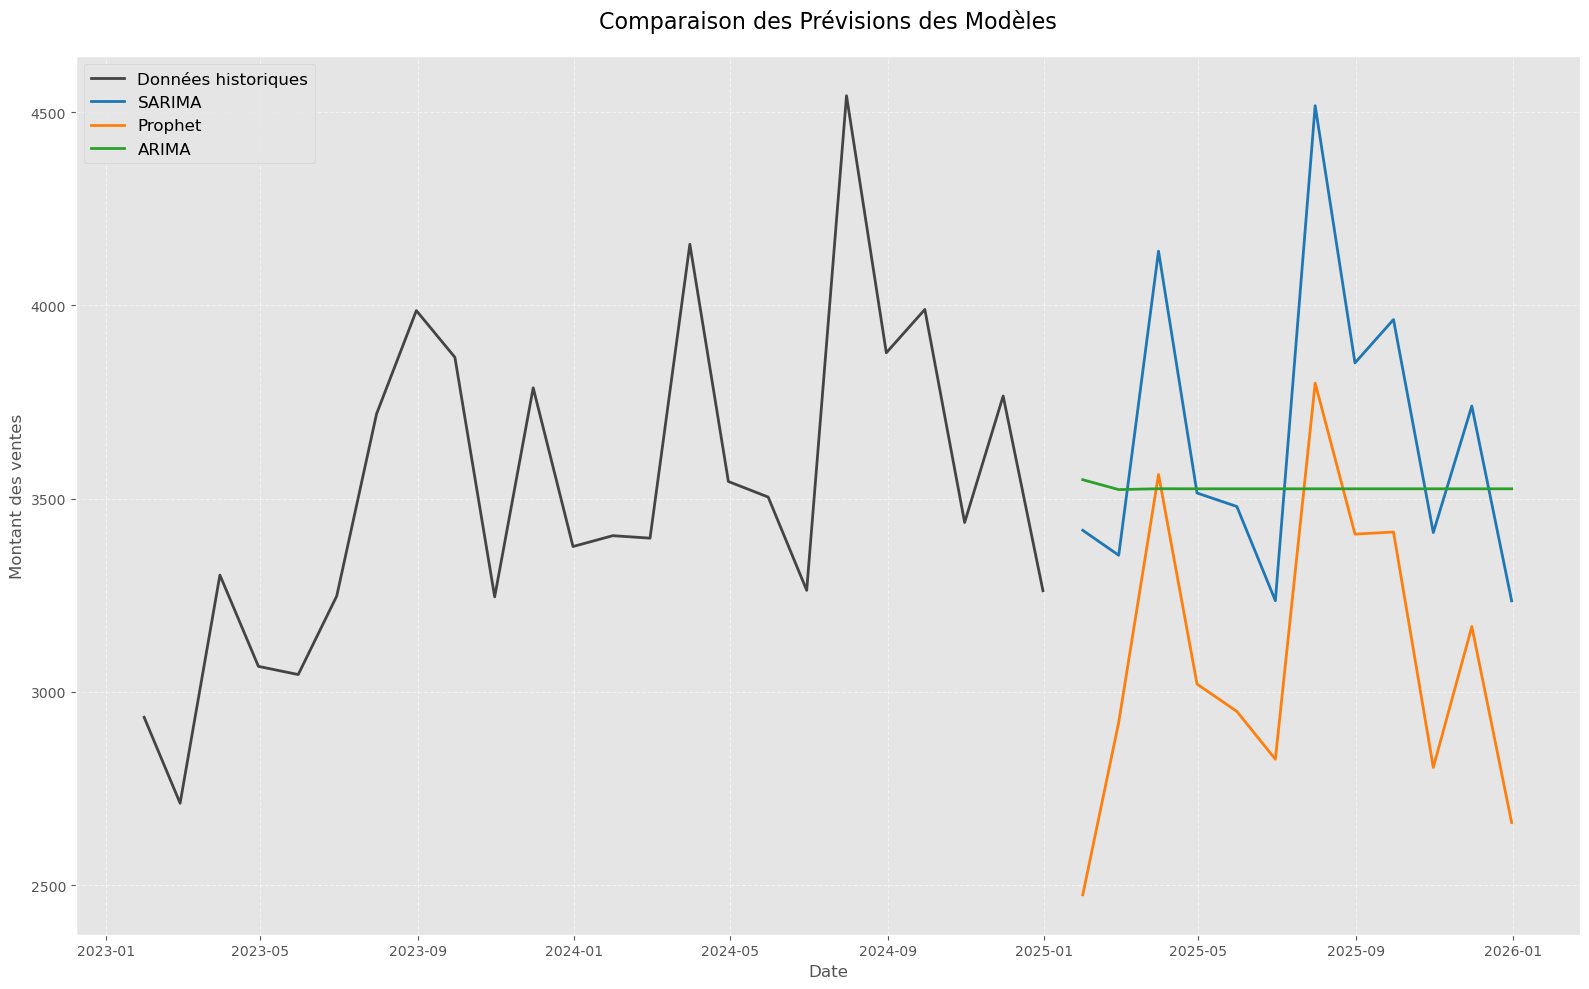

In [20]:
# ==============================================
# 6. VISUALISATION DE TOUS LES MODÈLES
# ==============================================

# Configuration commune
forecast_steps = 12
plt.style.use('ggplot')  # Style alternatif plus moderne
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Fonction pour visualiser un modèle
def plot_model_predictions(model_name, model, train, test=None):
    plt.figure(figsize=(14, 7))
    
    # 1. Plot historical data
    plt.plot(train.index, train, label='Données historiques', color=colors[0], linewidth=2)
    
    # Model-specific plotting
    if model_name == 'SARIMA':
        forecast = model.get_forecast(steps=forecast_steps)
        forecast_values = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps+1, freq='M')[1:]
        plt.plot(forecast_index, forecast_values, label='Prévisions', color=colors[1], linestyle='--', linewidth=2)
        plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], 
                        color=colors[1], alpha=0.2, label='Intervalle de confiance 95%')
        
    elif model_name == 'Prophet':
        future = model.make_future_dataframe(periods=forecast_steps, freq='M')
        forecast = model.predict(future)
        
        plt.plot(forecast['ds'], forecast['yhat'], label='Ajustement du modèle', color=colors[2], alpha=0.5)
        forecast_values = forecast['yhat'][-forecast_steps:]
        forecast_index = forecast['ds'][-forecast_steps:]
        plt.plot(forecast_index, forecast_values, label='Prévisions', color=colors[1], linestyle='--', linewidth=2)
        plt.fill_between(forecast_index, 
                        forecast['yhat_lower'][-forecast_steps:], 
                        forecast['yhat_upper'][-forecast_steps:],
                        color=colors[1], alpha=0.2, label='Intervalle de confiance 95%')
        
    elif model_name == 'ARIMA':
        forecast = model.get_forecast(steps=forecast_steps)
        forecast_values = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps+1, freq='M')[1:]
        plt.plot(forecast_index, forecast_values, label='Prévisions', color=colors[1], linestyle='--', linewidth=2)
        plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], 
                        color=colors[1], alpha=0.2, label='Intervalle de confiance 95%')
    
    # Dernière valeur connue
    last_value = train.iloc[-1]
    plt.scatter(train.index[-1], last_value, color='green', s=100, zorder=5, label='Dernière valeur connue')
    
    # Configuration du graphique
    plt.title(f'Prévisions des ventes - Modèle {model_name}', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Montant des ventes', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper left')
    plt.tight_layout()
    plt.show()

# 1. Visualisation SARIMA
print("\n=== Visualisation SARIMA ===")
sarima_model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
plot_model_predictions('SARIMA', sarima_model, monthly_sales)

# 2. Visualisation Prophet
print("\n=== Visualisation Prophet ===")
prophet_data = monthly_sales.reset_index()
prophet_data.columns = ['ds', 'y']
prophet_model = Prophet(yearly_seasonality=True, interval_width=0.95)
prophet_model.fit(prophet_data)
plot_model_predictions('Prophet', prophet_model, monthly_sales)

# 3. Visualisation ARIMA
print("\n=== Visualisation ARIMA ===")
arima_model = ARIMA(monthly_sales, order=(1,1,1)).fit()
plot_model_predictions('ARIMA', arima_model, monthly_sales)

# 4. Comparaison côte à côte
print("\n=== Comparaison visuelle des modèles ===")
plt.figure(figsize=(16, 10))

# Données historiques
plt.plot(monthly_sales.index, monthly_sales, label='Données historiques', color='black', linewidth=2, alpha=0.7)

# Prévisions de chaque modèle
forecast_dates = pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps+1, freq='M')[1:]

# SARIMA
sarima_forecast = sarima_model.get_forecast(steps=forecast_steps)
plt.plot(forecast_dates, sarima_forecast.predicted_mean, label='SARIMA', color=colors[0], linestyle='-', linewidth=2)

# Prophet
prophet_forecast = prophet_model.predict(prophet_model.make_future_dataframe(periods=forecast_steps, freq='M'))
plt.plot(forecast_dates, prophet_forecast['yhat'][-forecast_steps:], label='Prophet', color=colors[1], linestyle='-', linewidth=2)

# ARIMA
arima_forecast = arima_model.get_forecast(steps=forecast_steps)
plt.plot(forecast_dates, arima_forecast.predicted_mean, label='ARIMA', color=colors[2], linestyle='-', linewidth=2)

plt.title('Comparaison des Prévisions des Modèles', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Montant des ventes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# ==============================================
# SYSTÈME DE RECOMMANDATION HYBRIDE CORRIGÉ
# ==============================================

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix

# 1. Préparation des données corrigée
def prepare_data(merged_df, max_clients=5000, max_products=1000):
    """Charge et filtre les données avec cohérence dimensionnelle"""
    rec_data = merged_df[['Client_ID', 'ProduitComplet', 'Catégorie_Produit', 'prix', 'Quantite_Achetee']].dropna()
    
    # Optimisation des types de données
    rec_data['Quantite_Achetee'] = pd.to_numeric(rec_data['Quantite_Achetee'], downcast='unsigned')
    rec_data['prix'] = pd.to_numeric(rec_data['prix'], downcast='float')
    
    # Filtrage cohérent des clients et produits
    top_clients = rec_data['Client_ID'].value_counts().nlargest(max_clients).index
    rec_data = rec_data[rec_data['Client_ID'].isin(top_clients)]
    
    top_products = rec_data['ProduitComplet'].value_counts().nlargest(max_products).index
    rec_data = rec_data[rec_data['ProduitComplet'].isin(top_products)]
    
    return rec_data

rec_data = prepare_data(merged_df)

# 2. Approche hybride corrigée

# a. Filtrage collaboratif avec dimensions cohérentes
def create_consistent_matrix(data):
    """Crée une matrice utilisateur-produit avec dimensions cohérentes"""
    # Encodage des IDs avec les mêmes catégories
    client_encoder = pd.Categorical(data['Client_ID'])
    product_encoder = pd.Categorical(data['ProduitComplet'])
    
    # Matrice creuse
    matrix = csr_matrix(
        (data['Quantite_Achetee'], 
         (client_encoder.codes, product_encoder.codes)),
        shape=(len(client_encoder.categories), len(product_encoder.categories))
    )
    
    return matrix, client_encoder.categories, product_encoder.categories

user_item_sparse, client_ids, product_ids = create_consistent_matrix(rec_data)

# Normalisation avec dimensions vérifiées
scaler = MinMaxScaler()
# Normalisation des produits (en lignes)
user_item_normalized = scaler.fit_transform(user_item_sparse.toarray())

# Modèle KNN avec dimensions correctes
knn_model = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='brute')
knn_model.fit(user_item_normalized)  # Clients en lignes, produits en colonnes

# b. Filtrage basé sur le contenu
product_descriptions = rec_data[['ProduitComplet', 'Catégorie_Produit']].drop_duplicates().reset_index(drop=True)
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = tfidf.fit_transform(product_descriptions['ProduitComplet'])

# Calcul des similarités
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# 3. Fonction de recommandation corrigée
def recommend_products(client_id, n_recommendations=5, hybrid_weight=0.7):
    """Version corrigée avec gestion correcte des dimensions"""
    # Vérification client existant
    if client_id not in client_ids:
        top_products = rec_data.groupby('ProduitComplet')['Quantite_Achetee'].sum().nlargest(n_recommendations)
        print(f"\n⚠ Client {client_id} non trouvé. Voici les produits les plus populaires:")
        return pd.DataFrame({'Produit': top_products.index, 'Quantité Totale': top_products.values})
    
    # Filtrage collaboratif avec dimensions correctes
    client_idx = np.where(client_ids == client_id)[0][0]
    client_vector = user_item_normalized[client_idx].reshape(1, -1)
    
    # Vérification de la dimension
    if client_vector.shape[1] != user_item_normalized.shape[1]:
        raise ValueError(f"Dimension mismatch: client vector has {client_vector.shape[1]} features, expected {user_item_normalized.shape[1]}")
    
    distances, indices = knn_model.kneighbors(client_vector, n_neighbors=100)
    collab_scores = 1 - distances.squeeze()
    collab_products = product_ids[indices.squeeze()]
    
    # Filtrage contenu optimisé
    last_products = rec_data[rec_data['Client_ID'] == client_id]['ProduitComplet'].tail(3)
    content_rec = pd.DataFrame()
    
    for product in last_products:
        product_mask = product_descriptions['ProduitComplet'] == product
        if not product_mask.any():
            continue
            
        idx = product_descriptions[product_mask].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # Top 5 similaires
        
        temp_df = pd.DataFrame({
            'Produit': product_descriptions.iloc[[i for i, _ in sim_scores]]['ProduitComplet'],
            'Score_Contenu': [score for _, score in sim_scores]
        })
        content_rec = pd.concat([content_rec, temp_df])
    
    content_rec = content_rec.drop_duplicates('Produit')
    
    # Combinaison hybride
    collab_rec = pd.DataFrame({
        'Produit': collab_products,
        'Score_Collab': collab_scores
    }).drop_duplicates('Produit')
    
    hybrid_rec = pd.merge(collab_rec, content_rec, on='Produit', how='left').fillna(0)
    hybrid_rec['Score_Hybride'] = (hybrid_weight * hybrid_rec['Score_Collab'] + 
                                  (1 - hybrid_weight) * hybrid_rec['Score_Contenu'])
    
    # Exclure les produits déjà achetés
    purchased = rec_data[rec_data['Client_ID'] == client_id]['ProduitComplet'].unique()
    hybrid_rec = hybrid_rec[~hybrid_rec['Produit'].isin(purchased)]
    
    # Tri et sélection
    final_rec = hybrid_rec.sort_values('Score_Hybride', ascending=False).head(n_recommendations)
    
    # Ajout d'informations
    product_info = rec_data[['ProduitComplet', 'Catégorie_Produit', 'prix']].drop_duplicates()
    final_rec = pd.merge(final_rec, product_info, left_on='Produit', right_on='ProduitComplet')
    final_rec = final_rec[['Produit', 'Catégorie_Produit', 'prix', 'Score_Hybride']]
    final_rec.columns = ['Produit Recommandé', 'Catégorie', 'Prix Moyen', 'Score de Pertinence']
    
    return final_rec.round(2)

# 4. Visualisation
def plot_recommendations(recommendations, client_id):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Score de Pertinence', y='Produit Recommandé', 
                data=recommendations, palette='viridis')
    plt.title(f'Top Recommandations pour le Client {client_id}', pad=20)
    plt.xlabel('Score de Pertinence', fontsize=12)
    plt.ylabel('Produit', fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Test avec client spécifique
def test_system(data):
    sample_client = 8946  # Le client de votre exemple
    print(f"\n{'='*50}")
    print(f"⚡ ANALYSE CLIENT {sample_client}")
    print(f"{'='*50}")
    
    # Historique d'achat
    history = data[data['Client_ID'] == sample_client][['ProduitComplet', 'Quantite_Achetee', 'prix']]
    history['Dépense'] = history['Quantite_Achetee'] * history['prix']
    print("\n📜 Historique d'achat:")
    print(history.groupby('ProduitComplet').agg({
        'Quantite_Achetee': 'sum',
        'Dépense': 'sum'
    }).sort_values('Quantite_Achetee', ascending=False).head(5).to_markdown())
    
    # Recommandations
    recs = recommend_products(sample_client)
    print("\n🎯 Recommandations personnalisées:")
    print(recs.to_markdown(index=False))
    

test_system(rec_data)


⚡ ANALYSE CLIENT 8946

📜 Historique d'achat:
| ProduitComplet                              |   Quantite_Achetee |   Dépense |
|:--------------------------------------------|-------------------:|----------:|
| G-Masque capillaireHD400ML Silver Color...  |                  3 |     74.97 |
| G-Yaourt à boireNATILAIT160GR Pomme/vanille |                  1 |      0.94 |

🎯 Recommandations personnalisées:
| Produit Recommandé                                 | Catégorie   |   Prix Moyen |   Score de Pertinence |
|:---------------------------------------------------|:------------|-------------:|----------------------:|
| C-SCHWEPPES tonicSCHWEPPESLa bouteille de 1L       | Boisson     |         1.29 |                   0.7 |
| C-SCHWEPPES tonicSCHWEPPESLa bouteille de 1L       | Boisson     |         2.75 |                   0.7 |
| G-Anti-cernesMAYBELLINEN°05 Super stay concealer   | Hygiene     |        50.5  |                   0   |
| G-Après shampooingKERATINE TERAPY250ML Maintenance | 

In [22]:
# ==============================================
# SYSTÈME DE NOTIFICATION PAR EMAIL
# ==============================================

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [47]:
def send_email_notification(client_email, client_id, recommendations):
    """Envoie une notification email personnalisée avec les recommandations"""
    # Configuration du serveur SMTP - UPDATE THESE VALUES!
    smtp_server = "smtp.gmail.com"  # Example for Gmail
    port = 587
    sender_email = "keepallaffordable@gmail.com"  # Your real email
    password = "rgjg mdyy bytn wbte"  # Use app password for Gmail
    
    # Création du message
    message = MIMEMultipart("alternative")
    message["Subject"] = f"📢 Recommandations for the customer {client_id}"
    message["From"] = sender_email
    message["To"] = client_email
    
    # Contenu HTML du email
    html = f"""
<html>
  <body style="font-family: Arial, sans-serif; max-width: 600px; margin: 0 auto; padding: 20px;">
    <div style="background-color: #f8f9fa; padding: 20px; border-radius: 10px;">
      <h2 style="color: #2c3e50;">Your personalized recommendations</h2>
      <p style="font-size: 16px;">Here are the products we recommend :</p>
      
      <h3 style="color: #2c3e50;">Top recommandations :</h3>
      <ul style="list-style-type: none; padding: 0;">
""" 
    
    # Ajout des recommandations
    for _, row in recommendations.iterrows():
        html += f"""
        <li style="background-color: white; padding: 10px; margin-bottom: 5px; border-radius: 5px;">
          {row['Produit Recommandé']} 
          <span style="float: right; color: #3498db;">Price: {row['Prix Moyen']:.2f} DT</span>
          <br>
          <small>Category: {row['Catégorie']} </small>
        </li>
        """
    
    # Pied de page
    html += f"""
      </ul>
      <div style="text-align: center; margin-top: 20px;">
        <a href="https://www.votre-site.com/offres" 
           style="display: inline-block; background-color: #3498db; color: white; 
                  padding: 10px 20px; text-decoration: none; border-radius: 5px;">
          Voir toutes les offres
        </a>
      </div>
    </div>
    <p style="text-align: center; font-size: 12px; color: #7f8c8d; margin-top: 20px;">
      © {datetime.now().year} Keep All Affordable. All rights reserved.
    </p>
  </body>
</html>
"""
    # Envoi du email with enhanced error handling
    try:
        # Validate email format
        if "@" not in client_email or "." not in client_email.split("@")[1]:
            raise ValueError("Invalid email format")
            
        part = MIMEText(html, "html")
        message.attach(part)
        
        with smtplib.SMTP(smtp_server, port, timeout=10) as server:
            server.ehlo()
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, client_email, message.as_string())
        print(f"Email successfully sent to {client_email}")
        return True
        
    except smtplib.SMTPException as e:
        print(f"SMTP Error: {str(e)}")
    except Exception as e:
        print(f"General Error: {str(e)}")
    return False

# 5. Test avec client spécifique et envoi d'email
def test_system_and_send_email(data, client_email):
    sample_client = 8946  # Le client de votre exemple
    print(f"\n{'='*50}")
    print(f"⚡ ANALYSE CLIENT {sample_client}")
    print(f"{'='*50}")
    
    # Historique d'achat
    history = data[data['Client_ID'] == sample_client][['ProduitComplet', 'Quantite_Achetee', 'prix']]
    history['Dépense'] = history['Quantite_Achetee'] * history['prix']
    print("\n📜 Historique d'achat:")
    print(history.groupby('ProduitComplet').agg({
        'Quantite_Achetee': 'sum',
        'Dépense': 'sum'
    }).sort_values('Quantite_Achetee', ascending=False).head(5).to_markdown())
    
    # Recommandations
    recs = recommend_products(sample_client)
    print("\n🎯 Recommandations personnalisées:")
    print(recs.to_markdown(index=False))
    
    # Envoi de l'email
    if not recs.empty:
        send_email_notification(client_email, sample_client, recs)
    else:
        print("Aucune recommandation à envoyer par email.")

# Exemple d'utilisation
test_system_and_send_email(rec_data, "rania.bnhmida@gmail.com")


⚡ ANALYSE CLIENT 8946

📜 Historique d'achat:
| ProduitComplet                              |   Quantite_Achetee |   Dépense |
|:--------------------------------------------|-------------------:|----------:|
| G-Masque capillaireHD400ML Silver Color...  |                  3 |     74.97 |
| G-Yaourt à boireNATILAIT160GR Pomme/vanille |                  1 |      0.94 |

🎯 Recommandations personnalisées:
| Produit Recommandé                                 | Catégorie   |   Prix Moyen |   Score de Pertinence |
|:---------------------------------------------------|:------------|-------------:|----------------------:|
| C-SCHWEPPES tonicSCHWEPPESLa bouteille de 1L       | Boisson     |         1.29 |                   0.7 |
| C-SCHWEPPES tonicSCHWEPPESLa bouteille de 1L       | Boisson     |         2.75 |                   0.7 |
| G-Anti-cernesMAYBELLINEN°05 Super stay concealer   | Hygiene     |        50.5  |                   0   |
| G-Après shampooingKERATINE TERAPY250ML Maintenance | 